##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-10-27 06:20:26.659120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 06:20:26.659166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 06:20:26.660709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 0s

 5021696/68606236 [=>............................] - ETA: 0s

18669568/68606236 [=======>......................] - ETA: 0s

33718272/68606236 [=============>................] - ETA: 0s

49143808/68606236 [====================>.........] - ETA: 0s

64839680/68606236 [===========================>..] - ETA: 0s

68606236/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

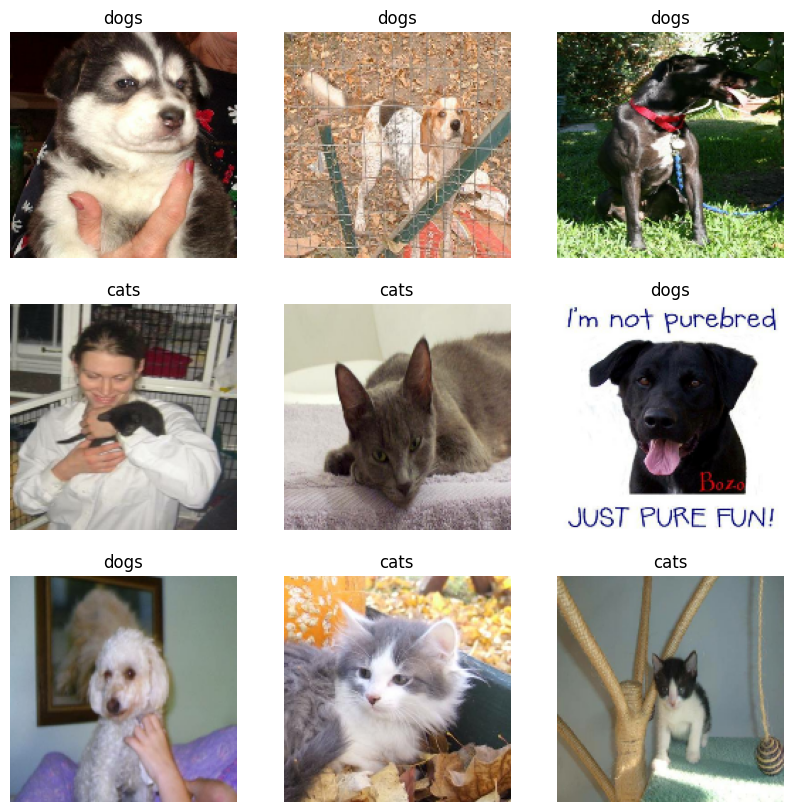

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

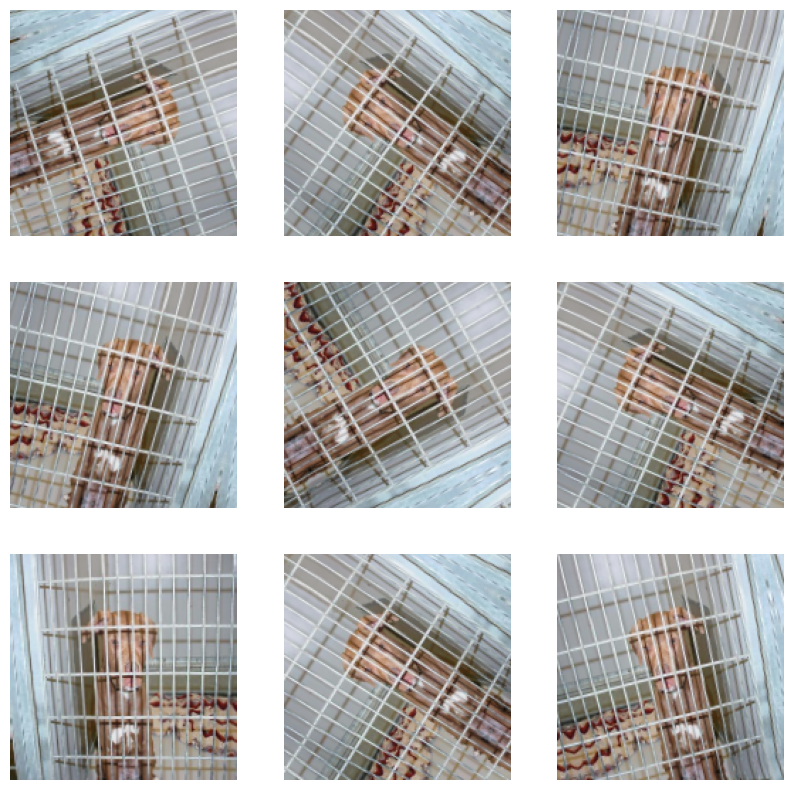

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

7192576/9406464 [=====================>........] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            


 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             


 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               


 on)                                                                                              


 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']            


 expanded_conv_depthwise (D  (None, 80, 80, 32)           288       ['Conv1_relu[0][0]']          


 epthwiseConv2D)                                                                                  


 expanded_conv_depthwise_BN  (None, 80, 80, 32)           128       ['expanded_conv_depthwise[0][0


  (BatchNormalization)                                              ]']                           


 expanded_conv_depthwise_re  (None, 80, 80, 32)           0         ['expanded_conv_depthwise_BN[0


 lu (ReLU)                                                          ][0]']                        


 expanded_conv_project (Con  (None, 80, 80, 16)           512       ['expanded_conv_depthwise_relu


 v2D)                                                               [0][0]']                      


 expanded_conv_project_BN (  (None, 80, 80, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 80, 80, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 80, 80, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     


 block_1_expand_relu (ReLU)  (None, 80, 80, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 81, 81, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


 block_1_depthwise (Depthwi  (None, 40, 40, 96)           864       ['block_1_pad[0][0]']         


 seConv2D)                                                                                        


 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']


 LU)                                                                                              


 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]


                                                                    ']                            


 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     


 ormalization)                                                                                    


 block_2_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_1_project_BN[0][0]']  


 block_2_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_2_expand[0][0]']      


 rmalization)                                                                                     


 block_2_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_2_expand_BN[0][0]']   


 block_2_depthwise (Depthwi  (None, 40, 40, 144)          1296      ['block_2_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_2_depthwise_BN (Batc  (None, 40, 40, 144)          576       ['block_2_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_2_depthwise_relu (Re  (None, 40, 40, 144)          0         ['block_2_depthwise_BN[0][0]']


 LU)                                                                                              


 block_2_project (Conv2D)    (None, 40, 40, 24)           3456      ['block_2_depthwise_relu[0][0]


                                                                    ']                            


 block_2_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_2_project[0][0]']     


 ormalization)                                                                                    


 block_2_add (Add)           (None, 40, 40, 24)           0         ['block_1_project_BN[0][0]',  


                                                                     'block_2_project_BN[0][0]']  


 block_3_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_2_add[0][0]']         


 block_3_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_3_expand[0][0]']      


 rmalization)                                                                                     


 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   


 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 


 )                                                                                                


 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         


 seConv2D)                                                                                        


 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_3_depthwise_relu (Re  (None, 20, 20, 144)          0         ['block_3_depthwise_BN[0][0]']


 LU)                                                                                              


 block_3_project (Conv2D)    (None, 20, 20, 32)           4608      ['block_3_depthwise_relu[0][0]


                                                                    ']                            


 block_3_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_3_project[0][0]']     


 ormalization)                                                                                    


 block_4_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_3_project_BN[0][0]']  


 block_4_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_4_expand[0][0]']      


 rmalization)                                                                                     


 block_4_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_4_expand_BN[0][0]']   


 block_4_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_4_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_4_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_4_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_4_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_4_depthwise_BN[0][0]']


 LU)                                                                                              


 block_4_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_4_depthwise_relu[0][0]


                                                                    ']                            


 block_4_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_4_project[0][0]']     


 ormalization)                                                                                    


 block_4_add (Add)           (None, 20, 20, 32)           0         ['block_3_project_BN[0][0]',  


                                                                     'block_4_project_BN[0][0]']  


 block_5_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_4_add[0][0]']         


 block_5_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_5_expand[0][0]']      


 rmalization)                                                                                     


 block_5_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_5_expand_BN[0][0]']   


 block_5_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_5_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_5_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_5_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_5_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_5_depthwise_BN[0][0]']


 LU)                                                                                              


 block_5_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_5_depthwise_relu[0][0]


                                                                    ']                            


 block_5_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_5_project[0][0]']     


 ormalization)                                                                                    


 block_5_add (Add)           (None, 20, 20, 32)           0         ['block_4_add[0][0]',         


                                                                     'block_5_project_BN[0][0]']  


 block_6_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_5_add[0][0]']         


 block_6_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_6_expand[0][0]']      


 rmalization)                                                                                     


 block_6_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_6_expand_BN[0][0]']   


 block_6_pad (ZeroPadding2D  (None, 21, 21, 192)          0         ['block_6_expand_relu[0][0]'] 


 )                                                                                                


 block_6_depthwise (Depthwi  (None, 10, 10, 192)          1728      ['block_6_pad[0][0]']         


 seConv2D)                                                                                        


 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']


 LU)                                                                                              


 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]


                                                                    ']                            


 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     


 ormalization)                                                                                    


 block_7_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_6_project_BN[0][0]']  


 block_7_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_7_expand[0][0]']      


 rmalization)                                                                                     


 block_7_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_7_expand_BN[0][0]']   


 block_7_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_7_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_7_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_7_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_7_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_7_depthwise_BN[0][0]']


 LU)                                                                                              


 block_7_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_7_depthwise_relu[0][0]


                                                                    ']                            


 block_7_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_7_project[0][0]']     


 ormalization)                                                                                    


 block_7_add (Add)           (None, 10, 10, 64)           0         ['block_6_project_BN[0][0]',  


                                                                     'block_7_project_BN[0][0]']  


 block_8_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_7_add[0][0]']         


 block_8_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_8_expand[0][0]']      


 rmalization)                                                                                     


 block_8_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_8_expand_BN[0][0]']   


 block_8_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_8_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_8_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_8_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_8_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_8_depthwise_BN[0][0]']


 LU)                                                                                              


 block_8_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_8_depthwise_relu[0][0]


                                                                    ']                            


 block_8_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_8_project[0][0]']     


 ormalization)                                                                                    


 block_8_add (Add)           (None, 10, 10, 64)           0         ['block_7_add[0][0]',         


                                                                     'block_8_project_BN[0][0]']  


 block_9_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_8_add[0][0]']         


 block_9_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_9_expand[0][0]']      


 rmalization)                                                                                     


 block_9_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_9_expand_BN[0][0]']   


 block_9_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_9_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_9_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_9_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_9_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_9_depthwise_BN[0][0]']


 LU)                                                                                              


 block_9_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_9_depthwise_relu[0][0]


                                                                    ']                            


 block_9_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_9_project[0][0]']     


 ormalization)                                                                                    


 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         


                                                                     'block_9_project_BN[0][0]']  


 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         


 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     


 ormalization)                                                                                    


 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  


 )                                                                                                


 block_10_depthwise (Depthw  (None, 10, 10, 384)          3456      ['block_10_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_10_depthwise_BN (Bat  (None, 10, 10, 384)          1536      ['block_10_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_10_depthwise_relu (R  (None, 10, 10, 384)          0         ['block_10_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_10_project (Conv2D)   (None, 10, 10, 96)           36864     ['block_10_depthwise_relu[0][0


                                                                    ]']                           


 block_10_project_BN (Batch  (None, 10, 10, 96)           384       ['block_10_project[0][0]']    


 Normalization)                                                                                   


 block_11_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_10_project_BN[0][0]'] 


 block_11_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_11_expand[0][0]']     


 ormalization)                                                                                    


 block_11_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_11_expand_BN[0][0]']  


 )                                                                                                


 block_11_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_11_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_11_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_11_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_11_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_11_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_11_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_11_depthwise_relu[0][0


                                                                    ]']                           


 block_11_project_BN (Batch  (None, 10, 10, 96)           384       ['block_11_project[0][0]']    


 Normalization)                                                                                   


 block_11_add (Add)          (None, 10, 10, 96)           0         ['block_10_project_BN[0][0]', 


                                                                     'block_11_project_BN[0][0]'] 


 block_12_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_11_add[0][0]']        


 block_12_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_12_expand[0][0]']     


 ormalization)                                                                                    


 block_12_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_12_expand_BN[0][0]']  


 )                                                                                                


 block_12_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_12_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_12_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_12_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_12_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_12_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_12_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_12_depthwise_relu[0][0


                                                                    ]']                           


 block_12_project_BN (Batch  (None, 10, 10, 96)           384       ['block_12_project[0][0]']    


 Normalization)                                                                                   


 block_12_add (Add)          (None, 10, 10, 96)           0         ['block_11_add[0][0]',        


                                                                     'block_12_project_BN[0][0]'] 


 block_13_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_12_add[0][0]']        


 block_13_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_13_expand[0][0]']     


 ormalization)                                                                                    


 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  


 )                                                                                                


 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']


 D)                                                                                               


 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        


 iseConv2D)                                                                                       


 block_13_depthwise_BN (Bat  (None, 5, 5, 576)            2304      ['block_13_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_13_depthwise_relu (R  (None, 5, 5, 576)            0         ['block_13_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_13_project (Conv2D)   (None, 5, 5, 160)            92160     ['block_13_depthwise_relu[0][0


                                                                    ]']                           


 block_13_project_BN (Batch  (None, 5, 5, 160)            640       ['block_13_project[0][0]']    


 Normalization)                                                                                   


 block_14_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_13_project_BN[0][0]'] 


 block_14_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_14_expand[0][0]']     


 ormalization)                                                                                    


 block_14_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_14_expand_BN[0][0]']  


 )                                                                                                


 block_14_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_14_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_14_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_14_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_14_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_14_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_14_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_14_depthwise_relu[0][0


                                                                    ]']                           


 block_14_project_BN (Batch  (None, 5, 5, 160)            640       ['block_14_project[0][0]']    


 Normalization)                                                                                   


 block_14_add (Add)          (None, 5, 5, 160)            0         ['block_13_project_BN[0][0]', 


                                                                     'block_14_project_BN[0][0]'] 


 block_15_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_14_add[0][0]']        


 block_15_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_15_expand[0][0]']     


 ormalization)                                                                                    


 block_15_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_15_expand_BN[0][0]']  


 )                                                                                                


 block_15_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_15_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_15_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_15_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_15_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_15_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_15_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_15_depthwise_relu[0][0


                                                                    ]']                           


 block_15_project_BN (Batch  (None, 5, 5, 160)            640       ['block_15_project[0][0]']    


 Normalization)                                                                                   


 block_15_add (Add)          (None, 5, 5, 160)            0         ['block_14_add[0][0]',        


                                                                     'block_15_project_BN[0][0]'] 


 block_16_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_15_add[0][0]']        


 block_16_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_16_expand[0][0]']     


 ormalization)                                                                                    


 block_16_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_16_expand_BN[0][0]']  


 )                                                                                                


 block_16_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_16_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0


                                                                    ]']                           


 block_16_project_BN (Batch  (None, 5, 5, 320)            1280      ['block_16_project[0][0]']    


 Normalization)                                                                                   


 Conv_1 (Conv2D)             (None, 5, 5, 1280)           409600    ['block_16_project_BN[0][0]'] 


 Conv_1_bn (BatchNormalizat  (None, 5, 5, 1280)           5120      ['Conv_1[0][0]']              


 ion)                                                                                             


 out_relu (ReLU)             (None, 5, 5, 1280)           0         ['Conv_1_bn[0][0]']           


Total params: 2257984 (8.61 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 2257984 (8.61 MB)


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

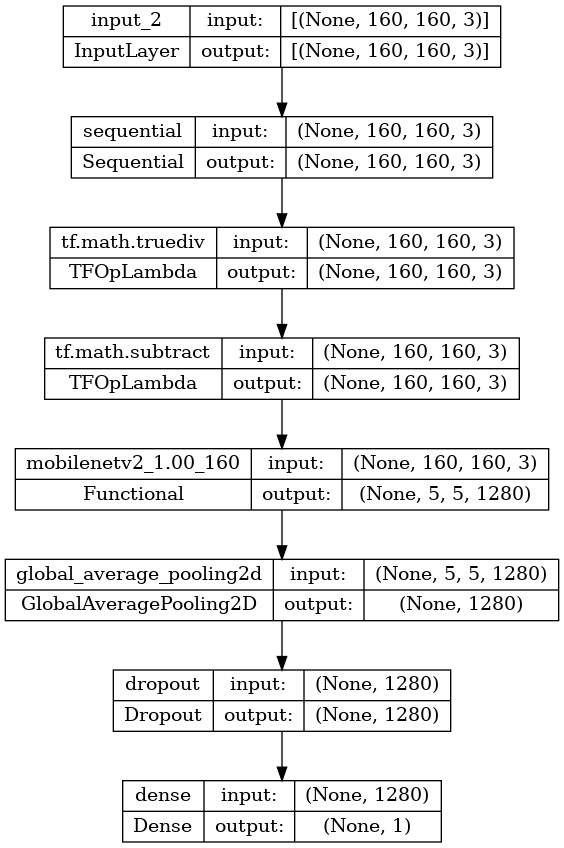

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 54s - loss: 0.8688 - accuracy: 0.3438

 4/26 [===>..........................] - ETA: 0s - loss: 0.8496 - accuracy: 0.4062 

 7/26 [=======>......................] - ETA: 0s - loss: 0.8524 - accuracy: 0.4062

10/26 [==========>...................] - ETA: 0s - loss: 0.8499 - accuracy: 0.4156

13/26 [==============>...............] - ETA: 0s - loss: 0.8606 - accuracy: 0.4087

16/26 [=================>............] - ETA: 0s - loss: 0.8754 - accuracy: 0.3926

19/26 [====================>.........] - ETA: 0s - loss: 0.8679 - accuracy: 0.3997

22/26 [========================>.....] - ETA: 0s - loss: 0.8676 - accuracy: 0.3935

25/26 [===========================>..] - ETA: 0s - loss: 0.8737 - accuracy: 0.3913

26/26 [==============================] - ETA: 0s - loss: 0.8721 - accuracy: 0.3936

26/26 [==============================] - 3s 51ms/step - loss: 0.8721 - accuracy: 0.3936


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.39


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 3:54 - loss: 0.6628 - accuracy: 0.5938

 3/63 [>.............................] - ETA: 2s - loss: 0.7223 - accuracy: 0.5521  

I0000 00:00:1698387645.781491  513626 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/63 [=>............................] - ETA: 1s - loss: 0.7462 - accuracy: 0.5562

 7/63 [==>...........................] - ETA: 1s - loss: 0.7562 - accuracy: 0.5357

 9/63 [===>..........................] - ETA: 1s - loss: 0.7898 - accuracy: 0.5347

11/63 [====>.........................] - ETA: 1s - loss: 0.7977 - accuracy: 0.5256

13/63 [=====>........................] - ETA: 1s - loss: 0.7927 - accuracy: 0.5264

15/63 [======>.......................] - ETA: 1s - loss: 0.7990 - accuracy: 0.5146

17/63 [=======>......................] - ETA: 1s - loss: 0.7998 - accuracy: 0.5055

20/63 [========>.....................] - ETA: 1s - loss: 0.7937 - accuracy: 0.5109

22/63 [=========>....................] - ETA: 1s - loss: 0.7897 - accuracy: 0.5128

25/63 [==========>...................] - ETA: 1s - loss: 0.7822 - accuracy: 0.5188

28/63 [============>.................] - ETA: 0s - loss: 0.7826 - accuracy: 0.5190

30/63 [=============>................] - ETA: 0s - loss: 0.7830 - accuracy: 0.5208

33/63 [==============>...............] - ETA: 0s - loss: 0.7714 - accuracy: 0.5275

36/63 [================>.............] - ETA: 0s - loss: 0.7606 - accuracy: 0.5382

39/63 [=================>............] - ETA: 0s - loss: 0.7605 - accuracy: 0.5369

41/63 [==================>...........] - ETA: 0s - loss: 0.7550 - accuracy: 0.5442

44/63 [===================>..........] - ETA: 0s - loss: 0.7521 - accuracy: 0.5440

47/63 [=====================>........] - ETA: 0s - loss: 0.7419 - accuracy: 0.5512

50/63 [======================>.......] - ETA: 0s - loss: 0.7326 - accuracy: 0.5594

53/63 [========================>.....] - ETA: 0s - loss: 0.7286 - accuracy: 0.5619

56/63 [=========================>....] - ETA: 0s - loss: 0.7218 - accuracy: 0.5686

59/63 [===========================>..] - ETA: 0s - loss: 0.7126 - accuracy: 0.5763

62/63 [============================>.] - ETA: 0s - loss: 0.7072 - accuracy: 0.5822

63/63 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.5820

63/63 [==============================] - 7s 48ms/step - loss: 0.7071 - accuracy: 0.5820 - val_loss: 0.5895 - val_accuracy: 0.6894


Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.6032 - accuracy: 0.7188

 3/63 [>.............................] - ETA: 1s - loss: 0.6826 - accuracy: 0.6146

 5/63 [=>............................] - ETA: 1s - loss: 0.6221 - accuracy: 0.6812

 8/63 [==>...........................] - ETA: 1s - loss: 0.6111 - accuracy: 0.6992

11/63 [====>.........................] - ETA: 1s - loss: 0.6034 - accuracy: 0.6960

13/63 [=====>........................] - ETA: 1s - loss: 0.5896 - accuracy: 0.6971

16/63 [======>.......................] - ETA: 1s - loss: 0.5919 - accuracy: 0.6855

18/63 [=======>......................] - ETA: 1s - loss: 0.5875 - accuracy: 0.6927

21/63 [=========>....................] - ETA: 1s - loss: 0.5880 - accuracy: 0.6905

23/63 [=========>....................] - ETA: 0s - loss: 0.5796 - accuracy: 0.6984

26/63 [===========>..................] - ETA: 0s - loss: 0.5739 - accuracy: 0.7019

29/63 [============>.................] - ETA: 0s - loss: 0.5630 - accuracy: 0.7069

32/63 [==============>...............] - ETA: 0s - loss: 0.5553 - accuracy: 0.7139

35/63 [===============>..............] - ETA: 0s - loss: 0.5525 - accuracy: 0.7179

37/63 [================>.............] - ETA: 0s - loss: 0.5507 - accuracy: 0.7179

40/63 [==================>...........] - ETA: 0s - loss: 0.5515 - accuracy: 0.7180

43/63 [===================>..........] - ETA: 0s - loss: 0.5503 - accuracy: 0.7202

45/63 [====================>.........] - ETA: 0s - loss: 0.5485 - accuracy: 0.7229

48/63 [=====================>........] - ETA: 0s - loss: 0.5466 - accuracy: 0.7227

51/63 [=======================>......] - ETA: 0s - loss: 0.5451 - accuracy: 0.7243

54/63 [========================>.....] - ETA: 0s - loss: 0.5399 - accuracy: 0.7292

57/63 [==========================>...] - ETA: 0s - loss: 0.5343 - accuracy: 0.7325

60/63 [===========================>..] - ETA: 0s - loss: 0.5287 - accuracy: 0.7380

63/63 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7435

63/63 [==============================] - 2s 34ms/step - loss: 0.5256 - accuracy: 0.7435 - val_loss: 0.4289 - val_accuracy: 0.8515


Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.4785 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 1s - loss: 0.4666 - accuracy: 0.7917

 5/63 [=>............................] - ETA: 1s - loss: 0.4521 - accuracy: 0.8125

 8/63 [==>...........................] - ETA: 1s - loss: 0.4570 - accuracy: 0.8086

11/63 [====>.........................] - ETA: 1s - loss: 0.4567 - accuracy: 0.8097

14/63 [=====>........................] - ETA: 1s - loss: 0.4425 - accuracy: 0.8147

16/63 [======>.......................] - ETA: 1s - loss: 0.4372 - accuracy: 0.8145

18/63 [=======>......................] - ETA: 1s - loss: 0.4401 - accuracy: 0.8090

21/63 [=========>....................] - ETA: 1s - loss: 0.4380 - accuracy: 0.8140

23/63 [=========>....................] - ETA: 0s - loss: 0.4316 - accuracy: 0.8207

26/63 [===========>..................] - ETA: 0s - loss: 0.4330 - accuracy: 0.8185

29/63 [============>.................] - ETA: 0s - loss: 0.4257 - accuracy: 0.8254

32/63 [==============>...............] - ETA: 0s - loss: 0.4196 - accuracy: 0.8271

35/63 [===============>..............] - ETA: 0s - loss: 0.4214 - accuracy: 0.8277

38/63 [=================>............] - ETA: 0s - loss: 0.4176 - accuracy: 0.8306

41/63 [==================>...........] - ETA: 0s - loss: 0.4159 - accuracy: 0.8316

44/63 [===================>..........] - ETA: 0s - loss: 0.4208 - accuracy: 0.8274

46/63 [====================>.........] - ETA: 0s - loss: 0.4208 - accuracy: 0.8261

49/63 [======================>.......] - ETA: 0s - loss: 0.4248 - accuracy: 0.8208

51/63 [=======================>......] - ETA: 0s - loss: 0.4231 - accuracy: 0.8229

54/63 [========================>.....] - ETA: 0s - loss: 0.4212 - accuracy: 0.8241

57/63 [==========================>...] - ETA: 0s - loss: 0.4184 - accuracy: 0.8262

60/63 [===========================>..] - ETA: 0s - loss: 0.4181 - accuracy: 0.8260

63/63 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8255

63/63 [==============================] - 2s 34ms/step - loss: 0.4175 - accuracy: 0.8255 - val_loss: 0.3403 - val_accuracy: 0.8936


Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.5060 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 1s - loss: 0.4511 - accuracy: 0.8333

 6/63 [=>............................] - ETA: 1s - loss: 0.4218 - accuracy: 0.8385

 9/63 [===>..........................] - ETA: 1s - loss: 0.4295 - accuracy: 0.8264

12/63 [====>.........................] - ETA: 1s - loss: 0.4022 - accuracy: 0.8490

15/63 [======>.......................] - ETA: 1s - loss: 0.3982 - accuracy: 0.8438

18/63 [=======>......................] - ETA: 1s - loss: 0.3939 - accuracy: 0.8472

21/63 [=========>....................] - ETA: 1s - loss: 0.3911 - accuracy: 0.8482

24/63 [==========>...................] - ETA: 0s - loss: 0.3872 - accuracy: 0.8477

27/63 [===========>..................] - ETA: 0s - loss: 0.3861 - accuracy: 0.8530

30/63 [=============>................] - ETA: 0s - loss: 0.3848 - accuracy: 0.8521

33/63 [==============>...............] - ETA: 0s - loss: 0.3838 - accuracy: 0.8494

36/63 [================>.............] - ETA: 0s - loss: 0.3858 - accuracy: 0.8472

39/63 [=================>............] - ETA: 0s - loss: 0.3874 - accuracy: 0.8446

42/63 [===================>..........] - ETA: 0s - loss: 0.3846 - accuracy: 0.8452

45/63 [====================>.........] - ETA: 0s - loss: 0.3843 - accuracy: 0.8472

48/63 [=====================>........] - ETA: 0s - loss: 0.3816 - accuracy: 0.8503

51/63 [=======================>......] - ETA: 0s - loss: 0.3785 - accuracy: 0.8517

54/63 [========================>.....] - ETA: 0s - loss: 0.3768 - accuracy: 0.8536

57/63 [==========================>...] - ETA: 0s - loss: 0.3773 - accuracy: 0.8547

60/63 [===========================>..] - ETA: 0s - loss: 0.3742 - accuracy: 0.8578

63/63 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8580

63/63 [==============================] - 2s 34ms/step - loss: 0.3714 - accuracy: 0.8580 - val_loss: 0.2727 - val_accuracy: 0.9307


Epoch 5/10


 1/63 [..............................] - ETA: 3s - loss: 0.3691 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 1s - loss: 0.3530 - accuracy: 0.8646

 5/63 [=>............................] - ETA: 1s - loss: 0.3120 - accuracy: 0.8938

 8/63 [==>...........................] - ETA: 1s - loss: 0.3135 - accuracy: 0.8945

10/63 [===>..........................] - ETA: 1s - loss: 0.3056 - accuracy: 0.9000

13/63 [=====>........................] - ETA: 1s - loss: 0.3011 - accuracy: 0.8990

15/63 [======>.......................] - ETA: 1s - loss: 0.3021 - accuracy: 0.8938

18/63 [=======>......................] - ETA: 1s - loss: 0.3193 - accuracy: 0.8837

21/63 [=========>....................] - ETA: 1s - loss: 0.3130 - accuracy: 0.8854

24/63 [==========>...................] - ETA: 0s - loss: 0.3150 - accuracy: 0.8776

27/63 [===========>..................] - ETA: 0s - loss: 0.3164 - accuracy: 0.8808

30/63 [=============>................] - ETA: 0s - loss: 0.3157 - accuracy: 0.8823

33/63 [==============>...............] - ETA: 0s - loss: 0.3142 - accuracy: 0.8788

36/63 [================>.............] - ETA: 0s - loss: 0.3179 - accuracy: 0.8759

39/63 [=================>............] - ETA: 0s - loss: 0.3195 - accuracy: 0.8782

42/63 [===================>..........] - ETA: 0s - loss: 0.3193 - accuracy: 0.8772

45/63 [====================>.........] - ETA: 0s - loss: 0.3145 - accuracy: 0.8799

48/63 [=====================>........] - ETA: 0s - loss: 0.3175 - accuracy: 0.8770

51/63 [=======================>......] - ETA: 0s - loss: 0.3228 - accuracy: 0.8744

54/63 [========================>.....] - ETA: 0s - loss: 0.3247 - accuracy: 0.8721

57/63 [==========================>...] - ETA: 0s - loss: 0.3197 - accuracy: 0.8745

60/63 [===========================>..] - ETA: 0s - loss: 0.3156 - accuracy: 0.8760

63/63 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8770

63/63 [==============================] - 2s 34ms/step - loss: 0.3141 - accuracy: 0.8770 - val_loss: 0.2309 - val_accuracy: 0.9381


Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.2266 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.2545 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 1s - loss: 0.2895 - accuracy: 0.9115

 9/63 [===>..........................] - ETA: 1s - loss: 0.2774 - accuracy: 0.9201

12/63 [====>.........................] - ETA: 1s - loss: 0.2752 - accuracy: 0.9193

15/63 [======>.......................] - ETA: 1s - loss: 0.2902 - accuracy: 0.9083

18/63 [=======>......................] - ETA: 1s - loss: 0.2896 - accuracy: 0.9062

21/63 [=========>....................] - ETA: 1s - loss: 0.2914 - accuracy: 0.9003

24/63 [==========>...................] - ETA: 0s - loss: 0.2889 - accuracy: 0.9049

27/63 [===========>..................] - ETA: 0s - loss: 0.2831 - accuracy: 0.9086

30/63 [=============>................] - ETA: 0s - loss: 0.2862 - accuracy: 0.9052

33/63 [==============>...............] - ETA: 0s - loss: 0.2846 - accuracy: 0.9044

36/63 [================>.............] - ETA: 0s - loss: 0.2863 - accuracy: 0.9010

39/63 [=================>............] - ETA: 0s - loss: 0.2860 - accuracy: 0.9014

42/63 [===================>..........] - ETA: 0s - loss: 0.2879 - accuracy: 0.9010

45/63 [====================>.........] - ETA: 0s - loss: 0.2851 - accuracy: 0.9021

48/63 [=====================>........] - ETA: 0s - loss: 0.2833 - accuracy: 0.9023

51/63 [=======================>......] - ETA: 0s - loss: 0.2828 - accuracy: 0.9007

54/63 [========================>.....] - ETA: 0s - loss: 0.2829 - accuracy: 0.9010

57/63 [==========================>...] - ETA: 0s - loss: 0.2830 - accuracy: 0.9008

60/63 [===========================>..] - ETA: 0s - loss: 0.2801 - accuracy: 0.9026

63/63 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9025

63/63 [==============================] - 2s 34ms/step - loss: 0.2792 - accuracy: 0.9025 - val_loss: 0.2043 - val_accuracy: 0.9443


Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.1743 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.2395 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 1s - loss: 0.2333 - accuracy: 0.9196

10/63 [===>..........................] - ETA: 1s - loss: 0.2455 - accuracy: 0.9094

12/63 [====>.........................] - ETA: 1s - loss: 0.2476 - accuracy: 0.9115

15/63 [======>.......................] - ETA: 1s - loss: 0.2469 - accuracy: 0.9146

18/63 [=======>......................] - ETA: 1s - loss: 0.2507 - accuracy: 0.9080

21/63 [=========>....................] - ETA: 1s - loss: 0.2575 - accuracy: 0.9048

24/63 [==========>...................] - ETA: 0s - loss: 0.2547 - accuracy: 0.9076

27/63 [===========>..................] - ETA: 0s - loss: 0.2583 - accuracy: 0.9062

30/63 [=============>................] - ETA: 0s - loss: 0.2589 - accuracy: 0.9052

33/63 [==============>...............] - ETA: 0s - loss: 0.2601 - accuracy: 0.9025

36/63 [================>.............] - ETA: 0s - loss: 0.2570 - accuracy: 0.9045

39/63 [=================>............] - ETA: 0s - loss: 0.2648 - accuracy: 0.8998

42/63 [===================>..........] - ETA: 0s - loss: 0.2673 - accuracy: 0.8988

45/63 [====================>.........] - ETA: 0s - loss: 0.2638 - accuracy: 0.9000

48/63 [=====================>........] - ETA: 0s - loss: 0.2665 - accuracy: 0.8984

51/63 [=======================>......] - ETA: 0s - loss: 0.2662 - accuracy: 0.8983

54/63 [========================>.....] - ETA: 0s - loss: 0.2647 - accuracy: 0.8981

57/63 [==========================>...] - ETA: 0s - loss: 0.2666 - accuracy: 0.8969

60/63 [===========================>..] - ETA: 0s - loss: 0.2649 - accuracy: 0.8974

63/63 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.8965

63/63 [==============================] - 2s 34ms/step - loss: 0.2639 - accuracy: 0.8965 - val_loss: 0.1805 - val_accuracy: 0.9554


Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.2072 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.1824 - accuracy: 0.9792

 6/63 [=>............................] - ETA: 1s - loss: 0.2040 - accuracy: 0.9323

 9/63 [===>..........................] - ETA: 1s - loss: 0.2245 - accuracy: 0.9236

12/63 [====>.........................] - ETA: 1s - loss: 0.2385 - accuracy: 0.9193

15/63 [======>.......................] - ETA: 1s - loss: 0.2259 - accuracy: 0.9271

18/63 [=======>......................] - ETA: 1s - loss: 0.2257 - accuracy: 0.9253

21/63 [=========>....................] - ETA: 1s - loss: 0.2316 - accuracy: 0.9211

24/63 [==========>...................] - ETA: 0s - loss: 0.2357 - accuracy: 0.9180

26/63 [===========>..................] - ETA: 0s - loss: 0.2351 - accuracy: 0.9171

29/63 [============>.................] - ETA: 0s - loss: 0.2384 - accuracy: 0.9159

31/63 [=============>................] - ETA: 0s - loss: 0.2392 - accuracy: 0.9173

34/63 [===============>..............] - ETA: 0s - loss: 0.2451 - accuracy: 0.9127

36/63 [================>.............] - ETA: 0s - loss: 0.2505 - accuracy: 0.9097

39/63 [=================>............] - ETA: 0s - loss: 0.2558 - accuracy: 0.9062

42/63 [===================>..........] - ETA: 0s - loss: 0.2545 - accuracy: 0.9077

45/63 [====================>.........] - ETA: 0s - loss: 0.2507 - accuracy: 0.9083

48/63 [=====================>........] - ETA: 0s - loss: 0.2501 - accuracy: 0.9082

51/63 [=======================>......] - ETA: 0s - loss: 0.2502 - accuracy: 0.9081

54/63 [========================>.....] - ETA: 0s - loss: 0.2453 - accuracy: 0.9109

57/63 [==========================>...] - ETA: 0s - loss: 0.2456 - accuracy: 0.9095

60/63 [===========================>..] - ETA: 0s - loss: 0.2425 - accuracy: 0.9120

62/63 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.9108

63/63 [==============================] - 2s 34ms/step - loss: 0.2417 - accuracy: 0.9110 - val_loss: 0.1650 - val_accuracy: 0.9592


Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.2022 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.1559 - accuracy: 0.9583

 5/63 [=>............................] - ETA: 1s - loss: 0.1701 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.1788 - accuracy: 0.9554

10/63 [===>..........................] - ETA: 1s - loss: 0.2208 - accuracy: 0.9281

13/63 [=====>........................] - ETA: 1s - loss: 0.2244 - accuracy: 0.9255

15/63 [======>.......................] - ETA: 1s - loss: 0.2198 - accuracy: 0.9229

18/63 [=======>......................] - ETA: 1s - loss: 0.2174 - accuracy: 0.9253

20/63 [========>.....................] - ETA: 1s - loss: 0.2216 - accuracy: 0.9219

23/63 [=========>....................] - ETA: 0s - loss: 0.2227 - accuracy: 0.9212

25/63 [==========>...................] - ETA: 0s - loss: 0.2193 - accuracy: 0.9225

28/63 [============>.................] - ETA: 0s - loss: 0.2188 - accuracy: 0.9219

31/63 [=============>................] - ETA: 0s - loss: 0.2243 - accuracy: 0.9183

34/63 [===============>..............] - ETA: 0s - loss: 0.2275 - accuracy: 0.9173

37/63 [================>.............] - ETA: 0s - loss: 0.2303 - accuracy: 0.9122

40/63 [==================>...........] - ETA: 0s - loss: 0.2282 - accuracy: 0.9133

42/63 [===================>..........] - ETA: 0s - loss: 0.2294 - accuracy: 0.9137

45/63 [====================>.........] - ETA: 0s - loss: 0.2347 - accuracy: 0.9111

47/63 [=====================>........] - ETA: 0s - loss: 0.2333 - accuracy: 0.9109

50/63 [======================>.......] - ETA: 0s - loss: 0.2348 - accuracy: 0.9100

53/63 [========================>.....] - ETA: 0s - loss: 0.2332 - accuracy: 0.9121

56/63 [=========================>....] - ETA: 0s - loss: 0.2353 - accuracy: 0.9102

59/63 [===========================>..] - ETA: 0s - loss: 0.2324 - accuracy: 0.9126

62/63 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9123

63/63 [==============================] - 2s 35ms/step - loss: 0.2313 - accuracy: 0.9120 - val_loss: 0.1523 - val_accuracy: 0.9604


Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.2807 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.1935 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 1s - loss: 0.1982 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9152

10/63 [===>..........................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9125

13/63 [=====>........................] - ETA: 1s - loss: 0.2157 - accuracy: 0.9135

15/63 [======>.......................] - ETA: 1s - loss: 0.2192 - accuracy: 0.9083

18/63 [=======>......................] - ETA: 1s - loss: 0.2161 - accuracy: 0.9149

20/63 [========>.....................] - ETA: 1s - loss: 0.2112 - accuracy: 0.9187

23/63 [=========>....................] - ETA: 0s - loss: 0.2139 - accuracy: 0.9185

26/63 [===========>..................] - ETA: 0s - loss: 0.2157 - accuracy: 0.9183

29/63 [============>.................] - ETA: 0s - loss: 0.2110 - accuracy: 0.9224

32/63 [==============>...............] - ETA: 0s - loss: 0.2118 - accuracy: 0.9180

34/63 [===============>..............] - ETA: 0s - loss: 0.2180 - accuracy: 0.9154

37/63 [================>.............] - ETA: 0s - loss: 0.2175 - accuracy: 0.9155

40/63 [==================>...........] - ETA: 0s - loss: 0.2205 - accuracy: 0.9133

43/63 [===================>..........] - ETA: 0s - loss: 0.2255 - accuracy: 0.9121

46/63 [====================>.........] - ETA: 0s - loss: 0.2275 - accuracy: 0.9117

48/63 [=====================>........] - ETA: 0s - loss: 0.2261 - accuracy: 0.9115

51/63 [=======================>......] - ETA: 0s - loss: 0.2247 - accuracy: 0.9124

54/63 [========================>.....] - ETA: 0s - loss: 0.2206 - accuracy: 0.9149

57/63 [==========================>...] - ETA: 0s - loss: 0.2191 - accuracy: 0.9156

60/63 [===========================>..] - ETA: 0s - loss: 0.2169 - accuracy: 0.9172

63/63 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9150

63/63 [==============================] - 2s 34ms/step - loss: 0.2201 - accuracy: 0.9150 - val_loss: 0.1379 - val_accuracy: 0.9666


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

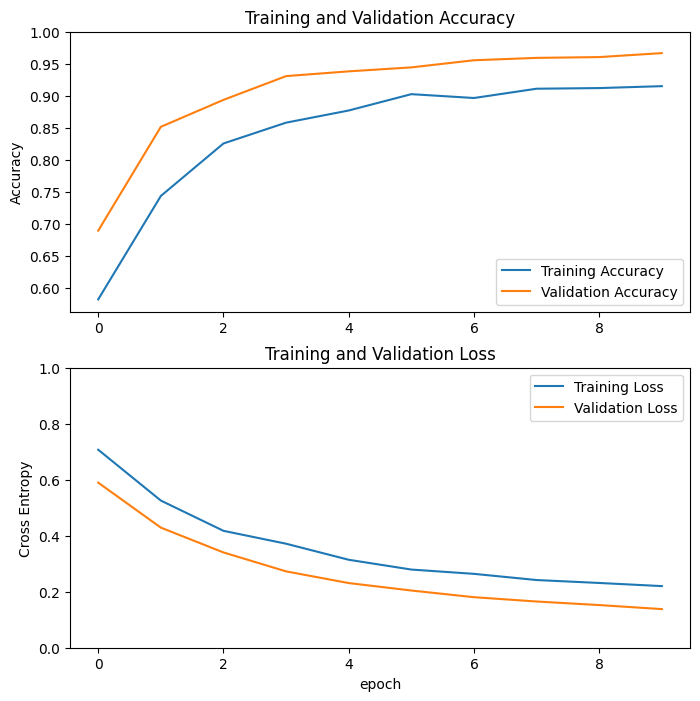

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [32]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 8:01 - loss: 0.1753 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1538 - accuracy: 0.9479  

 5/63 [=>............................] - ETA: 2s - loss: 0.1492 - accuracy: 0.9500

 7/63 [==>...........................] - ETA: 2s - loss: 0.1548 - accuracy: 0.9464

 9/63 [===>..........................] - ETA: 2s - loss: 0.1727 - accuracy: 0.9340

11/63 [====>.........................] - ETA: 2s - loss: 0.1605 - accuracy: 0.9403

13/63 [=====>........................] - ETA: 1s - loss: 0.1638 - accuracy: 0.9351

15/63 [======>.......................] - ETA: 1s - loss: 0.1583 - accuracy: 0.9396

17/63 [=======>......................] - ETA: 1s - loss: 0.1531 - accuracy: 0.9412

19/63 [========>.....................] - ETA: 1s - loss: 0.1554 - accuracy: 0.9375

21/63 [=========>....................] - ETA: 1s - loss: 0.1501 - accuracy: 0.9420

23/63 [=========>....................] - ETA: 1s - loss: 0.1494 - accuracy: 0.9429

25/63 [==========>...................] - ETA: 1s - loss: 0.1572 - accuracy: 0.9375

27/63 [===========>..................] - ETA: 1s - loss: 0.1571 - accuracy: 0.9363

29/63 [============>.................] - ETA: 1s - loss: 0.1618 - accuracy: 0.9343

31/63 [=============>................] - ETA: 1s - loss: 0.1648 - accuracy: 0.9325

33/63 [==============>...............] - ETA: 1s - loss: 0.1671 - accuracy: 0.9280

35/63 [===============>..............] - ETA: 0s - loss: 0.1675 - accuracy: 0.9295

37/63 [================>.............] - ETA: 0s - loss: 0.1672 - accuracy: 0.9291

39/63 [=================>............] - ETA: 0s - loss: 0.1664 - accuracy: 0.9295

41/63 [==================>...........] - ETA: 0s - loss: 0.1613 - accuracy: 0.9306

43/63 [===================>..........] - ETA: 0s - loss: 0.1627 - accuracy: 0.9302

45/63 [====================>.........] - ETA: 0s - loss: 0.1609 - accuracy: 0.9312

47/63 [=====================>........] - ETA: 0s - loss: 0.1597 - accuracy: 0.9322

49/63 [======================>.......] - ETA: 0s - loss: 0.1568 - accuracy: 0.9343

51/63 [=======================>......] - ETA: 0s - loss: 0.1578 - accuracy: 0.9326

53/63 [========================>.....] - ETA: 0s - loss: 0.1570 - accuracy: 0.9328

55/63 [=========================>....] - ETA: 0s - loss: 0.1570 - accuracy: 0.9324

57/63 [==========================>...] - ETA: 0s - loss: 0.1592 - accuracy: 0.9320

59/63 [===========================>..] - ETA: 0s - loss: 0.1587 - accuracy: 0.9322

61/63 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9329

63/63 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9335

63/63 [==============================] - 12s 64ms/step - loss: 0.1566 - accuracy: 0.9335 - val_loss: 0.0608 - val_accuracy: 0.9814


Epoch 11/20


 1/63 [..............................] - ETA: 4s - loss: 0.3441 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 2s - loss: 0.1747 - accuracy: 0.9167

 5/63 [=>............................] - ETA: 2s - loss: 0.1458 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 1s - loss: 0.1478 - accuracy: 0.9420

 9/63 [===>..........................] - ETA: 1s - loss: 0.1654 - accuracy: 0.9340

11/63 [====>.........................] - ETA: 1s - loss: 0.1643 - accuracy: 0.9290

13/63 [=====>........................] - ETA: 1s - loss: 0.1461 - accuracy: 0.9399

15/63 [======>.......................] - ETA: 1s - loss: 0.1381 - accuracy: 0.9417

17/63 [=======>......................] - ETA: 1s - loss: 0.1297 - accuracy: 0.9449

19/63 [========>.....................] - ETA: 1s - loss: 0.1342 - accuracy: 0.9457

21/63 [=========>....................] - ETA: 1s - loss: 0.1378 - accuracy: 0.9420

23/63 [=========>....................] - ETA: 1s - loss: 0.1400 - accuracy: 0.9416

25/63 [==========>...................] - ETA: 1s - loss: 0.1380 - accuracy: 0.9413

27/63 [===========>..................] - ETA: 1s - loss: 0.1397 - accuracy: 0.9410

29/63 [============>.................] - ETA: 1s - loss: 0.1391 - accuracy: 0.9397

31/63 [=============>................] - ETA: 1s - loss: 0.1390 - accuracy: 0.9405

33/63 [==============>...............] - ETA: 1s - loss: 0.1375 - accuracy: 0.9422

35/63 [===============>..............] - ETA: 0s - loss: 0.1412 - accuracy: 0.9420

37/63 [================>.............] - ETA: 0s - loss: 0.1427 - accuracy: 0.9417

39/63 [=================>............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9439

41/63 [==================>...........] - ETA: 0s - loss: 0.1364 - accuracy: 0.9444

43/63 [===================>..........] - ETA: 0s - loss: 0.1337 - accuracy: 0.9462

45/63 [====================>.........] - ETA: 0s - loss: 0.1389 - accuracy: 0.9451

47/63 [=====================>........] - ETA: 0s - loss: 0.1380 - accuracy: 0.9455

49/63 [======================>.......] - ETA: 0s - loss: 0.1365 - accuracy: 0.9445

51/63 [=======================>......] - ETA: 0s - loss: 0.1342 - accuracy: 0.9461

53/63 [========================>.....] - ETA: 0s - loss: 0.1343 - accuracy: 0.9452

55/63 [=========================>....] - ETA: 0s - loss: 0.1324 - accuracy: 0.9460

57/63 [==========================>...] - ETA: 0s - loss: 0.1315 - accuracy: 0.9457

59/63 [===========================>..] - ETA: 0s - loss: 0.1279 - accuracy: 0.9476

61/63 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9493

63/63 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9495

63/63 [==============================] - 3s 44ms/step - loss: 0.1242 - accuracy: 0.9495 - val_loss: 0.0499 - val_accuracy: 0.9851


Epoch 12/20


 1/63 [..............................] - ETA: 4s - loss: 0.0365 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0471 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0592 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 1s - loss: 0.0659 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.0693 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 1s - loss: 0.0768 - accuracy: 0.9631

13/63 [=====>........................] - ETA: 1s - loss: 0.0876 - accuracy: 0.9567

15/63 [======>.......................] - ETA: 1s - loss: 0.0841 - accuracy: 0.9604

17/63 [=======>......................] - ETA: 1s - loss: 0.0898 - accuracy: 0.9596

19/63 [========>.....................] - ETA: 1s - loss: 0.0947 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9613

23/63 [=========>....................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9647

25/63 [==========>...................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9638

27/63 [===========>..................] - ETA: 1s - loss: 0.0869 - accuracy: 0.9653

29/63 [============>.................] - ETA: 1s - loss: 0.0864 - accuracy: 0.9655

31/63 [=============>................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9627

33/63 [==============>...............] - ETA: 1s - loss: 0.1024 - accuracy: 0.9574

35/63 [===============>..............] - ETA: 0s - loss: 0.1017 - accuracy: 0.9589

37/63 [================>.............] - ETA: 0s - loss: 0.1001 - accuracy: 0.9595

39/63 [=================>............] - ETA: 0s - loss: 0.1054 - accuracy: 0.9567

41/63 [==================>...........] - ETA: 0s - loss: 0.1025 - accuracy: 0.9581

43/63 [===================>..........] - ETA: 0s - loss: 0.1012 - accuracy: 0.9586

45/63 [====================>.........] - ETA: 0s - loss: 0.1018 - accuracy: 0.9590

47/63 [=====================>........] - ETA: 0s - loss: 0.1056 - accuracy: 0.9561

49/63 [======================>.......] - ETA: 0s - loss: 0.1122 - accuracy: 0.9528

51/63 [=======================>......] - ETA: 0s - loss: 0.1126 - accuracy: 0.9534

53/63 [========================>.....] - ETA: 0s - loss: 0.1106 - accuracy: 0.9552

55/63 [=========================>....] - ETA: 0s - loss: 0.1091 - accuracy: 0.9557

57/63 [==========================>...] - ETA: 0s - loss: 0.1072 - accuracy: 0.9567

59/63 [===========================>..] - ETA: 0s - loss: 0.1075 - accuracy: 0.9555

61/63 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9559

63/63 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9565

63/63 [==============================] - 3s 44ms/step - loss: 0.1048 - accuracy: 0.9565 - val_loss: 0.0623 - val_accuracy: 0.9814


Epoch 13/20


 1/63 [..............................] - ETA: 4s - loss: 0.0554 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0633 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0565 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 1s - loss: 0.0653 - accuracy: 0.9659

13/63 [=====>........................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9663

15/63 [======>.......................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0769 - accuracy: 0.9632

19/63 [========>.....................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.0871 - accuracy: 0.9598

23/63 [=========>....................] - ETA: 1s - loss: 0.0943 - accuracy: 0.9552

25/63 [==========>...................] - ETA: 1s - loss: 0.0886 - accuracy: 0.9588

27/63 [===========>..................] - ETA: 1s - loss: 0.0910 - accuracy: 0.9583

29/63 [============>.................] - ETA: 1s - loss: 0.0928 - accuracy: 0.9569

31/63 [=============>................] - ETA: 1s - loss: 0.0898 - accuracy: 0.9587

33/63 [==============>...............] - ETA: 1s - loss: 0.0873 - accuracy: 0.9602

35/63 [===============>..............] - ETA: 0s - loss: 0.0864 - accuracy: 0.9607

37/63 [================>.............] - ETA: 0s - loss: 0.0916 - accuracy: 0.9595

39/63 [=================>............] - ETA: 0s - loss: 0.0910 - accuracy: 0.9599

41/63 [==================>...........] - ETA: 0s - loss: 0.0873 - accuracy: 0.9619

43/63 [===================>..........] - ETA: 0s - loss: 0.0900 - accuracy: 0.9608

45/63 [====================>.........] - ETA: 0s - loss: 0.0891 - accuracy: 0.9618

47/63 [=====================>........] - ETA: 0s - loss: 0.0878 - accuracy: 0.9628

49/63 [======================>.......] - ETA: 0s - loss: 0.0876 - accuracy: 0.9630

51/63 [=======================>......] - ETA: 0s - loss: 0.0887 - accuracy: 0.9632

53/63 [========================>.....] - ETA: 0s - loss: 0.0884 - accuracy: 0.9634

55/63 [=========================>....] - ETA: 0s - loss: 0.0879 - accuracy: 0.9631

57/63 [==========================>...] - ETA: 0s - loss: 0.0872 - accuracy: 0.9627

59/63 [===========================>..] - ETA: 0s - loss: 0.0857 - accuracy: 0.9640

61/63 [============================>.] - ETA: 0s - loss: 0.0854 - accuracy: 0.9636

63/63 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9640

63/63 [==============================] - 3s 44ms/step - loss: 0.0843 - accuracy: 0.9640 - val_loss: 0.0564 - val_accuracy: 0.9765


Epoch 14/20


 1/63 [..............................] - ETA: 4s - loss: 0.0379 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0748 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0776 - accuracy: 0.9750

 7/63 [==>...........................] - ETA: 1s - loss: 0.0991 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.1158 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.1169 - accuracy: 0.9545

13/63 [=====>........................] - ETA: 1s - loss: 0.1205 - accuracy: 0.9495

15/63 [======>.......................] - ETA: 1s - loss: 0.1137 - accuracy: 0.9500

17/63 [=======>......................] - ETA: 1s - loss: 0.1088 - accuracy: 0.9522

19/63 [========>.....................] - ETA: 1s - loss: 0.1023 - accuracy: 0.9556

21/63 [=========>....................] - ETA: 1s - loss: 0.1049 - accuracy: 0.9509

23/63 [=========>....................] - ETA: 1s - loss: 0.1006 - accuracy: 0.9538

25/63 [==========>...................] - ETA: 1s - loss: 0.0998 - accuracy: 0.9550

27/63 [===========>..................] - ETA: 1s - loss: 0.1002 - accuracy: 0.9549

29/63 [============>.................] - ETA: 1s - loss: 0.0975 - accuracy: 0.9569

31/63 [=============>................] - ETA: 1s - loss: 0.0992 - accuracy: 0.9567

33/63 [==============>...............] - ETA: 1s - loss: 0.0992 - accuracy: 0.9564

35/63 [===============>..............] - ETA: 0s - loss: 0.1007 - accuracy: 0.9571

37/63 [================>.............] - ETA: 0s - loss: 0.1046 - accuracy: 0.9561

39/63 [=================>............] - ETA: 0s - loss: 0.1010 - accuracy: 0.9583

41/63 [==================>...........] - ETA: 0s - loss: 0.1000 - accuracy: 0.9581

43/63 [===================>..........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9571

45/63 [====================>.........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9569

47/63 [=====================>........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9581

49/63 [======================>.......] - ETA: 0s - loss: 0.1013 - accuracy: 0.9566

51/63 [=======================>......] - ETA: 0s - loss: 0.1028 - accuracy: 0.9553

53/63 [========================>.....] - ETA: 0s - loss: 0.1004 - accuracy: 0.9570

55/63 [=========================>....] - ETA: 0s - loss: 0.1020 - accuracy: 0.9574

57/63 [==========================>...] - ETA: 0s - loss: 0.1043 - accuracy: 0.9572

59/63 [===========================>..] - ETA: 0s - loss: 0.1045 - accuracy: 0.9571

61/63 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9580

63/63 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9590

63/63 [==============================] - 3s 44ms/step - loss: 0.1010 - accuracy: 0.9590 - val_loss: 0.0400 - val_accuracy: 0.9839


Epoch 15/20


 1/63 [..............................] - ETA: 4s - loss: 0.0376 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0325 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 2s - loss: 0.0374 - accuracy: 0.9937

 7/63 [==>...........................] - ETA: 1s - loss: 0.0701 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 1s - loss: 0.0674 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.0614 - accuracy: 0.9830

13/63 [=====>........................] - ETA: 1s - loss: 0.0591 - accuracy: 0.9832

15/63 [======>.......................] - ETA: 1s - loss: 0.0564 - accuracy: 0.9833

17/63 [=======>......................] - ETA: 1s - loss: 0.0666 - accuracy: 0.9761

19/63 [========>.....................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9737

21/63 [=========>....................] - ETA: 1s - loss: 0.0668 - accuracy: 0.9747

23/63 [=========>....................] - ETA: 1s - loss: 0.0690 - accuracy: 0.9742

25/63 [==========>...................] - ETA: 1s - loss: 0.0692 - accuracy: 0.9737

27/63 [===========>..................] - ETA: 1s - loss: 0.0694 - accuracy: 0.9734

29/63 [============>.................] - ETA: 1s - loss: 0.0722 - accuracy: 0.9720

31/63 [=============>................] - ETA: 1s - loss: 0.0805 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 1s - loss: 0.0816 - accuracy: 0.9688

35/63 [===============>..............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9670

37/63 [================>.............] - ETA: 0s - loss: 0.0882 - accuracy: 0.9637

39/63 [=================>............] - ETA: 0s - loss: 0.0913 - accuracy: 0.9623

41/63 [==================>...........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 0s - loss: 0.0882 - accuracy: 0.9637

45/63 [====================>.........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9653

47/63 [=====================>........] - ETA: 0s - loss: 0.0841 - accuracy: 0.9648

49/63 [======================>.......] - ETA: 0s - loss: 0.0828 - accuracy: 0.9656

51/63 [=======================>......] - ETA: 0s - loss: 0.0820 - accuracy: 0.9657

53/63 [========================>.....] - ETA: 0s - loss: 0.0834 - accuracy: 0.9646

55/63 [=========================>....] - ETA: 0s - loss: 0.0831 - accuracy: 0.9648

57/63 [==========================>...] - ETA: 0s - loss: 0.0824 - accuracy: 0.9649

59/63 [===========================>..] - ETA: 0s - loss: 0.0809 - accuracy: 0.9656

61/63 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9657

63/63 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9665

63/63 [==============================] - 3s 45ms/step - loss: 0.0802 - accuracy: 0.9665 - val_loss: 0.0508 - val_accuracy: 0.9777


Epoch 16/20


 1/63 [..............................] - ETA: 4s - loss: 0.0135 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0279 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 2s - loss: 0.0641 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 1s - loss: 0.0676 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 1s - loss: 0.0709 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 1s - loss: 0.0814 - accuracy: 0.9631

13/63 [=====>........................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9591

15/63 [======>.......................] - ETA: 1s - loss: 0.0840 - accuracy: 0.9625

17/63 [=======>......................] - ETA: 1s - loss: 0.0827 - accuracy: 0.9632

19/63 [========>.....................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9655

21/63 [=========>....................] - ETA: 1s - loss: 0.0708 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 1s - loss: 0.0697 - accuracy: 0.9700

27/63 [===========>..................] - ETA: 1s - loss: 0.0681 - accuracy: 0.9699

29/63 [============>.................] - ETA: 1s - loss: 0.0704 - accuracy: 0.9688

31/63 [=============>................] - ETA: 1s - loss: 0.0677 - accuracy: 0.9698

33/63 [==============>...............] - ETA: 1s - loss: 0.0691 - accuracy: 0.9697

35/63 [===============>..............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9652

37/63 [================>.............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9662

39/63 [=================>............] - ETA: 0s - loss: 0.0730 - accuracy: 0.9655

41/63 [==================>...........] - ETA: 0s - loss: 0.0752 - accuracy: 0.9649

43/63 [===================>..........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9666

45/63 [====================>.........] - ETA: 0s - loss: 0.0805 - accuracy: 0.9632

47/63 [=====================>........] - ETA: 0s - loss: 0.0777 - accuracy: 0.9648

49/63 [======================>.......] - ETA: 0s - loss: 0.0776 - accuracy: 0.9643

51/63 [=======================>......] - ETA: 0s - loss: 0.0812 - accuracy: 0.9626

53/63 [========================>.....] - ETA: 0s - loss: 0.0795 - accuracy: 0.9640

55/63 [=========================>....] - ETA: 0s - loss: 0.0801 - accuracy: 0.9642

57/63 [==========================>...] - ETA: 0s - loss: 0.0791 - accuracy: 0.9644

59/63 [===========================>..] - ETA: 0s - loss: 0.0774 - accuracy: 0.9650

61/63 [============================>.] - ETA: 0s - loss: 0.0776 - accuracy: 0.9652

63/63 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9655

63/63 [==============================] - 3s 45ms/step - loss: 0.0765 - accuracy: 0.9655 - val_loss: 0.0396 - val_accuracy: 0.9827


Epoch 17/20


 1/63 [..............................] - ETA: 4s - loss: 0.0434 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0323 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0438 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 1s - loss: 0.0359 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 1s - loss: 0.0354 - accuracy: 0.9861

11/63 [====>.........................] - ETA: 1s - loss: 0.0504 - accuracy: 0.9830

13/63 [=====>........................] - ETA: 1s - loss: 0.0552 - accuracy: 0.9808

15/63 [======>.......................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0569 - accuracy: 0.9816

19/63 [========>.....................] - ETA: 1s - loss: 0.0570 - accuracy: 0.9819

21/63 [=========>....................] - ETA: 1s - loss: 0.0572 - accuracy: 0.9821

23/63 [=========>....................] - ETA: 1s - loss: 0.0605 - accuracy: 0.9810

25/63 [==========>...................] - ETA: 1s - loss: 0.0574 - accuracy: 0.9825

27/63 [===========>..................] - ETA: 1s - loss: 0.0599 - accuracy: 0.9815

29/63 [============>.................] - ETA: 1s - loss: 0.0589 - accuracy: 0.9817

31/63 [=============>................] - ETA: 1s - loss: 0.0561 - accuracy: 0.9829

33/63 [==============>...............] - ETA: 1s - loss: 0.0566 - accuracy: 0.9820

35/63 [===============>..............] - ETA: 0s - loss: 0.0572 - accuracy: 0.9812

37/63 [================>.............] - ETA: 0s - loss: 0.0562 - accuracy: 0.9814

39/63 [=================>............] - ETA: 0s - loss: 0.0543 - accuracy: 0.9824

41/63 [==================>...........] - ETA: 0s - loss: 0.0587 - accuracy: 0.9802

43/63 [===================>..........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9804

45/63 [====================>.........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9806

47/63 [=====================>........] - ETA: 0s - loss: 0.0600 - accuracy: 0.9794

49/63 [======================>.......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9790

51/63 [=======================>......] - ETA: 0s - loss: 0.0621 - accuracy: 0.9792

53/63 [========================>.....] - ETA: 0s - loss: 0.0631 - accuracy: 0.9782

55/63 [=========================>....] - ETA: 0s - loss: 0.0626 - accuracy: 0.9784

57/63 [==========================>...] - ETA: 0s - loss: 0.0615 - accuracy: 0.9792

59/63 [===========================>..] - ETA: 0s - loss: 0.0612 - accuracy: 0.9793

61/63 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9795

63/63 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9800

63/63 [==============================] - 3s 45ms/step - loss: 0.0589 - accuracy: 0.9800 - val_loss: 0.0366 - val_accuracy: 0.9864


Epoch 18/20


 1/63 [..............................] - ETA: 4s - loss: 0.1378 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.1287 - accuracy: 0.9479

 5/63 [=>............................] - ETA: 2s - loss: 0.0918 - accuracy: 0.9625

 7/63 [==>...........................] - ETA: 1s - loss: 0.0897 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9757

11/63 [====>.........................] - ETA: 1s - loss: 0.0742 - accuracy: 0.9773

13/63 [=====>........................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9760

15/63 [======>.......................] - ETA: 1s - loss: 0.0793 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 1s - loss: 0.0731 - accuracy: 0.9779

19/63 [========>.....................] - ETA: 1s - loss: 0.0765 - accuracy: 0.9770

21/63 [=========>....................] - ETA: 1s - loss: 0.0804 - accuracy: 0.9747

23/63 [=========>....................] - ETA: 1s - loss: 0.0799 - accuracy: 0.9742

25/63 [==========>...................] - ETA: 1s - loss: 0.0820 - accuracy: 0.9750

27/63 [===========>..................] - ETA: 1s - loss: 0.0792 - accuracy: 0.9757

29/63 [============>.................] - ETA: 1s - loss: 0.0757 - accuracy: 0.9763

31/63 [=============>................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9778

33/63 [==============>...............] - ETA: 1s - loss: 0.0729 - accuracy: 0.9773

35/63 [===============>..............] - ETA: 0s - loss: 0.0743 - accuracy: 0.9759

37/63 [================>.............] - ETA: 0s - loss: 0.0721 - accuracy: 0.9764

39/63 [=================>............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9768

41/63 [==================>...........] - ETA: 0s - loss: 0.0678 - accuracy: 0.9779

43/63 [===================>..........] - ETA: 0s - loss: 0.0684 - accuracy: 0.9775

45/63 [====================>.........] - ETA: 0s - loss: 0.0736 - accuracy: 0.9750

47/63 [=====================>........] - ETA: 0s - loss: 0.0719 - accuracy: 0.9761

49/63 [======================>.......] - ETA: 0s - loss: 0.0736 - accuracy: 0.9739

51/63 [=======================>......] - ETA: 0s - loss: 0.0724 - accuracy: 0.9743

53/63 [========================>.....] - ETA: 0s - loss: 0.0710 - accuracy: 0.9746

55/63 [=========================>....] - ETA: 0s - loss: 0.0705 - accuracy: 0.9750

57/63 [==========================>...] - ETA: 0s - loss: 0.0700 - accuracy: 0.9742

59/63 [===========================>..] - ETA: 0s - loss: 0.0696 - accuracy: 0.9746

61/63 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9754

63/63 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9755

63/63 [==============================] - 3s 45ms/step - loss: 0.0684 - accuracy: 0.9755 - val_loss: 0.0433 - val_accuracy: 0.9889


Epoch 19/20


 1/63 [..............................] - ETA: 4s - loss: 0.0500 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0339 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0242 - accuracy: 0.9875

 7/63 [==>...........................] - ETA: 1s - loss: 0.0335 - accuracy: 0.9866

 9/63 [===>..........................] - ETA: 1s - loss: 0.0496 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 1s - loss: 0.0517 - accuracy: 0.9744

13/63 [=====>........................] - ETA: 1s - loss: 0.0497 - accuracy: 0.9760

15/63 [======>.......................] - ETA: 1s - loss: 0.0489 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 1s - loss: 0.0507 - accuracy: 0.9779

19/63 [========>.....................] - ETA: 1s - loss: 0.0523 - accuracy: 0.9786

21/63 [=========>....................] - ETA: 1s - loss: 0.0512 - accuracy: 0.9792

23/63 [=========>....................] - ETA: 1s - loss: 0.0526 - accuracy: 0.9783

25/63 [==========>...................] - ETA: 1s - loss: 0.0564 - accuracy: 0.9787

27/63 [===========>..................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9757

29/63 [============>.................] - ETA: 1s - loss: 0.0579 - accuracy: 0.9763

31/63 [=============>................] - ETA: 1s - loss: 0.0585 - accuracy: 0.9768

33/63 [==============>...............] - ETA: 1s - loss: 0.0568 - accuracy: 0.9773

35/63 [===============>..............] - ETA: 0s - loss: 0.0581 - accuracy: 0.9759

37/63 [================>.............] - ETA: 0s - loss: 0.0598 - accuracy: 0.9764

39/63 [=================>............] - ETA: 0s - loss: 0.0606 - accuracy: 0.9752

41/63 [==================>...........] - ETA: 0s - loss: 0.0603 - accuracy: 0.9748

43/63 [===================>..........] - ETA: 0s - loss: 0.0588 - accuracy: 0.9753

45/63 [====================>.........] - ETA: 0s - loss: 0.0583 - accuracy: 0.9757

47/63 [=====================>........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9754

49/63 [======================>.......] - ETA: 0s - loss: 0.0620 - accuracy: 0.9745

51/63 [=======================>......] - ETA: 0s - loss: 0.0644 - accuracy: 0.9724

53/63 [========================>.....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9729

55/63 [=========================>....] - ETA: 0s - loss: 0.0649 - accuracy: 0.9722

57/63 [==========================>...] - ETA: 0s - loss: 0.0663 - accuracy: 0.9720

59/63 [===========================>..] - ETA: 0s - loss: 0.0656 - accuracy: 0.9725

61/63 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9718

63/63 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9725

63/63 [==============================] - 3s 45ms/step - loss: 0.0651 - accuracy: 0.9725 - val_loss: 0.0415 - val_accuracy: 0.9851


Epoch 20/20


 1/63 [..............................] - ETA: 4s - loss: 0.0746 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0932 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0585 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 1s - loss: 0.0587 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 1s - loss: 0.0518 - accuracy: 0.9826

11/63 [====>.........................] - ETA: 1s - loss: 0.0498 - accuracy: 0.9830

13/63 [=====>........................] - ETA: 1s - loss: 0.0556 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 1s - loss: 0.0579 - accuracy: 0.9761

19/63 [========>.....................] - ETA: 1s - loss: 0.0553 - accuracy: 0.9770

21/63 [=========>....................] - ETA: 1s - loss: 0.0601 - accuracy: 0.9747

23/63 [=========>....................] - ETA: 1s - loss: 0.0565 - accuracy: 0.9769

25/63 [==========>...................] - ETA: 1s - loss: 0.0559 - accuracy: 0.9775

27/63 [===========>..................] - ETA: 1s - loss: 0.0538 - accuracy: 0.9792

29/63 [============>.................] - ETA: 1s - loss: 0.0542 - accuracy: 0.9784

31/63 [=============>................] - ETA: 1s - loss: 0.0557 - accuracy: 0.9768

33/63 [==============>...............] - ETA: 1s - loss: 0.0564 - accuracy: 0.9773

35/63 [===============>..............] - ETA: 0s - loss: 0.0574 - accuracy: 0.9768

37/63 [================>.............] - ETA: 0s - loss: 0.0581 - accuracy: 0.9764

39/63 [=================>............] - ETA: 0s - loss: 0.0576 - accuracy: 0.9760

41/63 [==================>...........] - ETA: 0s - loss: 0.0582 - accuracy: 0.9764

43/63 [===================>..........] - ETA: 0s - loss: 0.0589 - accuracy: 0.9753

45/63 [====================>.........] - ETA: 0s - loss: 0.0607 - accuracy: 0.9750

47/63 [=====================>........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9761

49/63 [======================>.......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9758

51/63 [=======================>......] - ETA: 0s - loss: 0.0610 - accuracy: 0.9755

53/63 [========================>.....] - ETA: 0s - loss: 0.0603 - accuracy: 0.9758

55/63 [=========================>....] - ETA: 0s - loss: 0.0590 - accuracy: 0.9761

57/63 [==========================>...] - ETA: 0s - loss: 0.0575 - accuracy: 0.9770

59/63 [===========================>..] - ETA: 0s - loss: 0.0585 - accuracy: 0.9762

61/63 [============================>.] - ETA: 0s - loss: 0.0582 - accuracy: 0.9764

63/63 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9760

63/63 [==============================] - 3s 45ms/step - loss: 0.0589 - accuracy: 0.9760 - val_loss: 0.0654 - val_accuracy: 0.9802


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

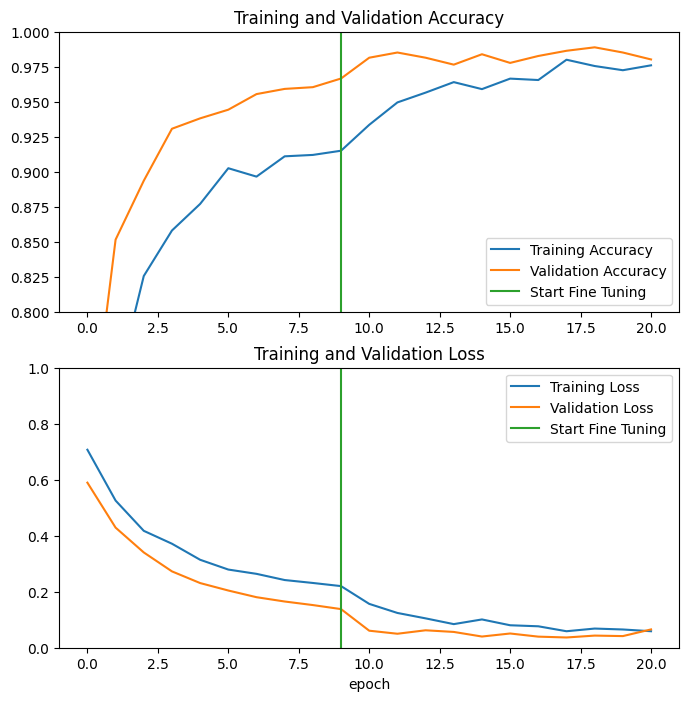

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0118 - accuracy: 1.0000

4/6 [===================>..........] - ETA: 0s - loss: 0.0282 - accuracy: 0.9922

6/6 [==============================] - 0s 24ms/step - loss: 0.0397 - accuracy: 0.9896


Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1]
Labels:
 [0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1]


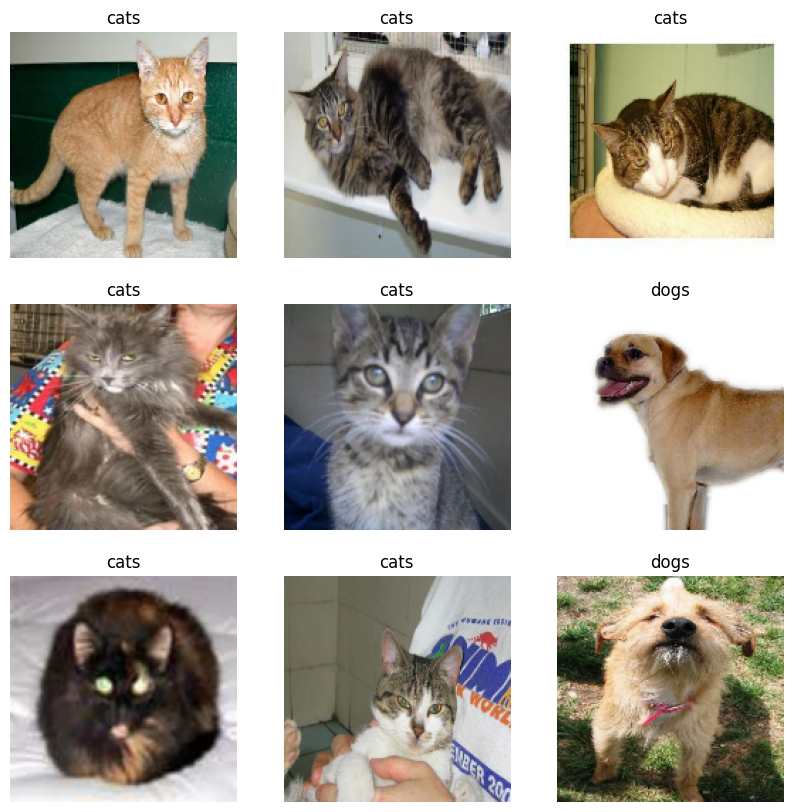

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
